In [1]:
import os, sys
sys.path.append("/home/files/feature_orthogonality")
from utils.session_config import setup_gpus

In [2]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
setup_gpus(memory_fraction=0.2)

1 Physical GPUs, 1 Logical GPUs


# Load mnist images

In [4]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
train_x = train_x[:,:,:,tf.newaxis]/255.
ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(32)
test_x = test_x[:,:,:,tf.newaxis]/255.
print(train_x.shape)
print(test_x.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

# Build Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = tf.keras.Sequential()
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model(tf.keras.Input(shape=(28,28,1)))

In [ ]:
model.save("cnn_initialized.h5")

In [12]:
model = tf.keras.models.load_model("cnn_initialized.h5")

In [13]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD()
for epoch in range(10):
    for x,y in ds:
        with tf.GradientTape() as tape:
            pred = model(x)
            loss = loss_fn(y,pred)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
model.compile(optimizer='SGD', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['acc'])
model.fit(train_x, train_y, epochs=10, shuffle=False)


In [ ]:
model.evaluate(test_x, test_y)

# Visualization

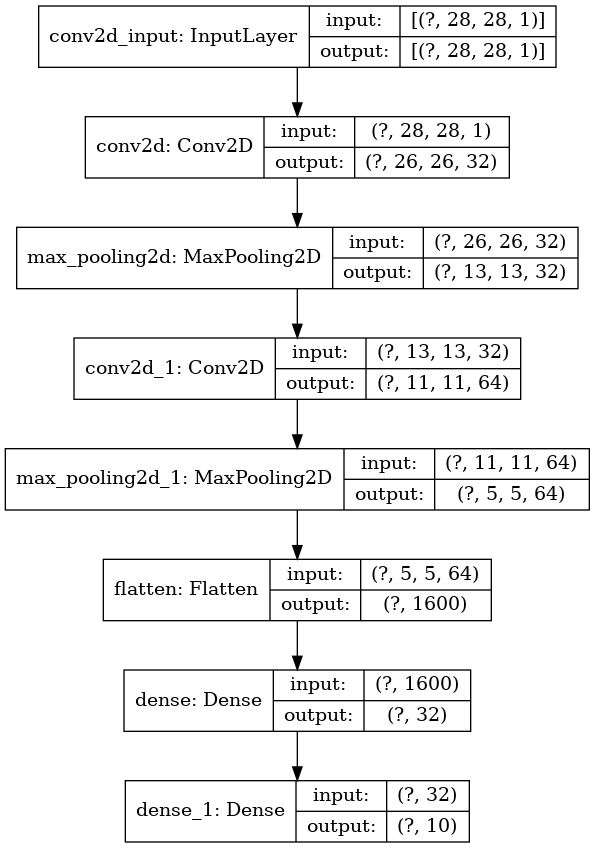

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
def get_weight_cosine_similarity(weight):
    w = weight
    if len(w) == 4: #convolution
        H,W,C,N = w.shape
        row_dims = H*W*C
        col_dims = N
    else: #dense
        D,N = w.shape
        row_dims = D
        col_dims = N
    w = tf.reshape(w, (row_dims, col_dims))
    norm = tf.norm(w, axis=0)
    w = w/norm #normalize
    wT = tf.transpose(w)
    correlations = tf.matmul(wT,w)
    return correlations

def get_weight_l2norm(weight):
    w = weight
    if len(w) == 4: #convolution
        H,W,C,N = w.shape
        row_dims = H*W*C
        col_dims = N
    else: #dense
        D,N = w.shape
        row_dims = D
        col_dims = N
    w = tf.reshape(w, (row_dims, col_dims))
    norm = tf.norm(w, axis=0)
    return norm

In [16]:
weight = model.get_layer("dense_1").get_weights()[0]
correlations = get_weight_cosine_similarity(weight)

<AxesSubplot:>

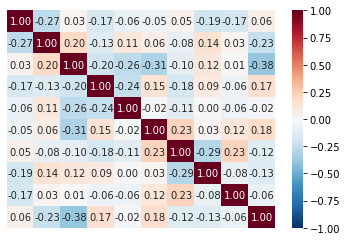

In [17]:
sns.heatmap(correlations, vmin=-1, vmax=1, cmap='RdBu_r', center=0, annot=True, fmt='.2f',xticklabels=False, yticklabels=False)

In [ ]:
norm = get_weight_l2norm(weight)
plt.bar(range(10), norm)
plt.title('Norm of weights', fontsize=20)
plt.show()

In [ ]:
norm